In [20]:
import numpy as np  
import matplotlib.pyplot as plt 
from scipy import linalg

import sequence_jacobian as sj
from winding_number import winding_number

## Preliminary setup
We'll follow `Tutorial 2 Monetary Policy.ipynb` and create an augmented household block that allows for arbitrary cyclicality of household risk, with the cyclicality parametrized by $\zeta$. This will be useful once we look at determinacy.

In [21]:
hh = sj.hetblocks.hh_sim.hh

def income_cyclical(Y, e_grid, e_pdf, zeta):
    y = Y * e_grid ** (1 + zeta * np.log(Y)) / np.vdot(e_grid ** (1 + zeta * np.log(Y)), e_pdf)
    return y

def make_grids_pdf(rho_e, sd_e, n_e, min_a, max_a, n_a):
    # need new make_grids that exports pdf
    e_grid, e_pdf, Pi = sj.grids.markov_rouwenhorst(rho_e, sd_e, n_e)
    a_grid = sj.grids.asset_grid(min_a, max_a, n_a)
    return e_grid, e_pdf, Pi, a_grid

hh = hh.add_hetinputs([income_cyclical, make_grids_pdf])

Then we'll just make a steady state with the default calibration, assuming $\zeta=0$ (acyclical risk) to start.

In [22]:
calib = sj.hetblocks.hh_sim.example_calibration()
calib['zeta'], calib['Y'] = 0, 1
ss = hh.steady_state(calib)

## Visualizing convergence of M matrix diagonals, fake news matrix

In [23]:
M = hh.jacobian(ss, inputs=['Y'], outputs=['C'], T=100)['C', 'Y']

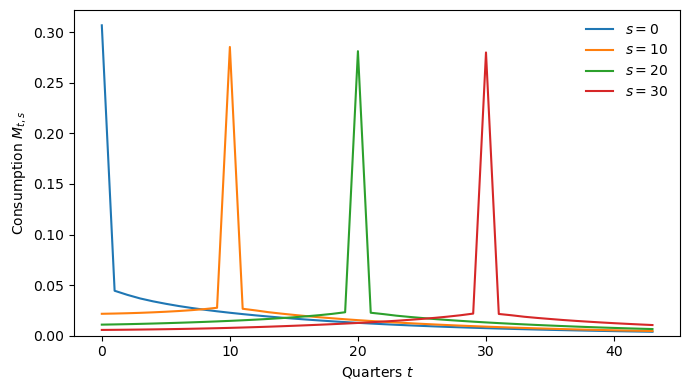

In [24]:
plt.figure(figsize=(7, 4))
plt.plot(M[:44, [0, 10, 20, 30]], lw=1.5)
plt.ylim(0, None)
plt.ylabel('Consumption $M_{t,s}$')
plt.xlabel('Quarters $t$')
plt.legend(['$s=0$', '$s=10$', '$s=20$', '$s=30$'], frameon=False)
plt.tight_layout()
#plt.savefig('figmatt/convergence.png', dpi=300, transparent=True)

Now calculate corresponding fake news matrix by taking first differences along the diagonals:

In [25]:
F = M.copy()
F[1:, 1:] -= F[:-1, :-1]

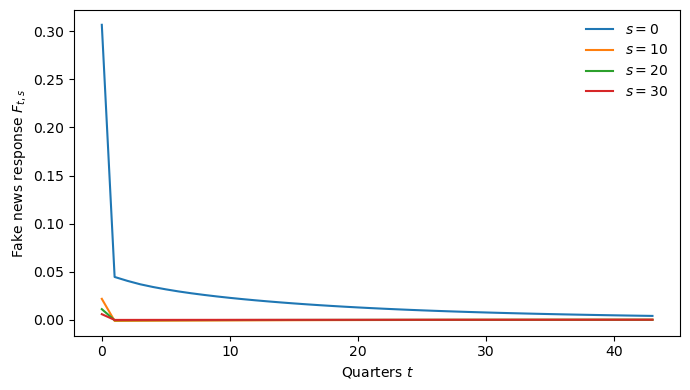

In [26]:
plt.figure(figsize=(7, 4))
plt.plot(F[:44, [0, 10, 20, 30]], lw=1.5)
plt.ylabel('Fake news response $F_{t,s}$')
plt.xlabel('Quarters $t$')
plt.legend(['$s=0$', '$s=10$', '$s=20$', '$s=30$'], frameon=False)
plt.tight_layout()
#plt.savefig('figmatt/fakenews_convergence.png', dpi=300, transparent=True)

# Apply winding number test to asset Jacobian
We'll consider a case with acyclical risk and also with countercyclical risk.

0

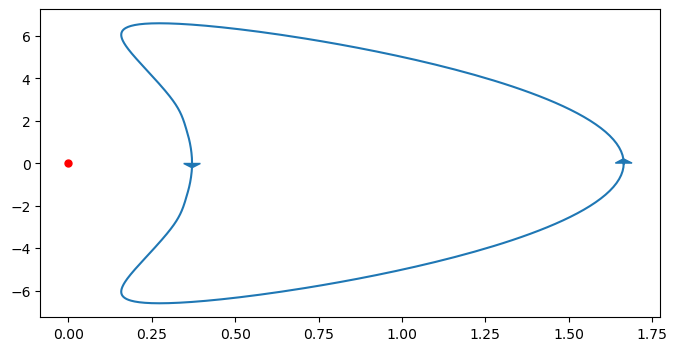

In [27]:
T = 1000
A = hh.jacobian(ss, inputs=['Y'], outputs=['A'], T=T)['A', 'Y']

# take final column and then final (reversed) row to get best estimate of Toeplitz
a = np.concatenate((A[:, -1], A[-1, :-1][::-1]))

# what is winding number in our default case?
plt.figure(figsize=(8, 4))
winding_number(a, plot=True)
#plt.savefig('figmatt/winding_number_basic.png', dpi=300, transparent=True)

In [28]:
ss_alt = ss.copy()
ss_alt['zeta'] = -0.4
A_alt = hh.jacobian(ss_alt, inputs=['Y'], outputs=['A'], T=T)['A', 'Y']
a_alt = np.concatenate((A_alt[:, -1], A_alt[-1, :-1][::-1]))

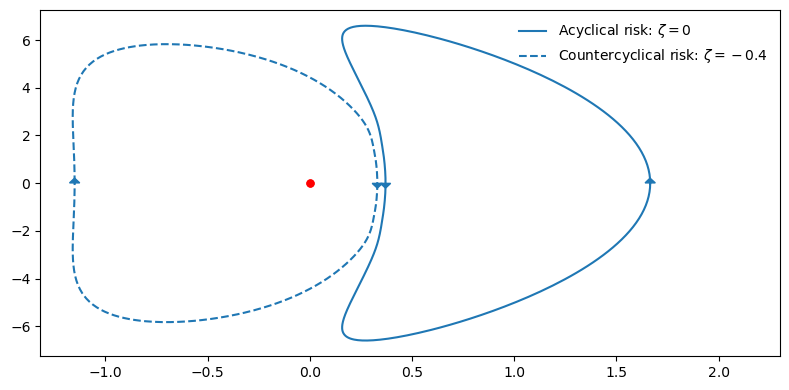

In [29]:
plt.figure(figsize=(8, 4))
(winding_number(a, plot=True, label='Acyclical risk: $\zeta=0$'),
winding_number(a_alt, plot=True, linestyle='--', label='Countercyclical risk: $\zeta=-0.4$'))
plt.xlim(None, 2.3)
plt.legend(frameon=False, loc='upper right')
plt.tight_layout()
#plt.savefig('figmatt/winding_number_two.png', dpi=300, transparent=True)

What does the multiplicity look like in the indeterminate case? Can use the singular value decomposition to find the vector that is nearly in the null-space of `A_alt`, which corresponds to a self-fulfilling fluctuation in output:

In [30]:
U, s, Vh = np.linalg.svd(A_alt)
s[-5:]

array([0.33048511, 0.33048226, 0.33048023, 0.33047901, 0.00398561])

5.734277909194563e-05


Text(0.5, 1.0, 'Self-fulfilling boom in output')

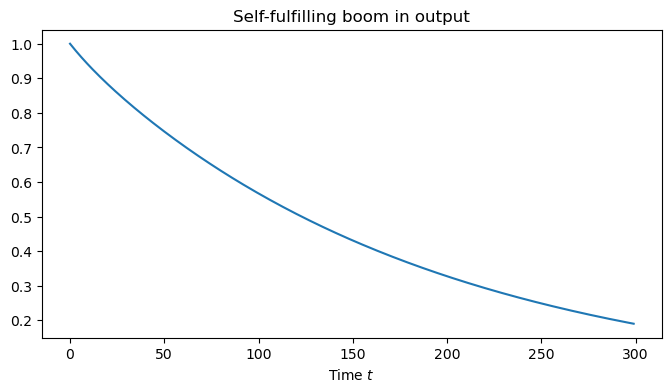

In [31]:
mult = Vh[-1, :300]
mult /= mult[0] # normalize so that output starts at +1
print(np.max(np.abs((A_alt[:300, :300] @ mult))[:150])) # test close to zero
plt.figure(figsize=(8, 4))
plt.plot(mult)
plt.xlabel('Time $t$')
plt.title('Self-fulfilling boom in output')
#plt.savefig('figmatt/multiplicity.png', dpi=300, transparent=True)

Now let's iterate over various levels of $\zeta$ and plot the winding number in each case, to see when the model is determinate or not:

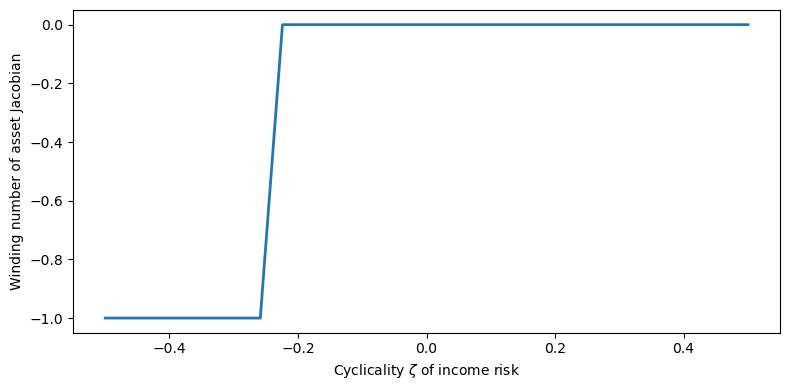

In [32]:
zetas = np.linspace(-0.5, 0.5, 30)
wn = np.empty_like(zetas)
for i, zeta in enumerate(zetas):
    ss_alt['zeta'] = zeta
    A_alt = hh.jacobian(ss_alt, inputs=['Y'], outputs=['A'], T=T)['A', 'Y']
    a_alt = np.concatenate((A_alt[:, -1], A_alt[-1, :-1][::-1]))
    wn[i] = winding_number(a_alt)
plt.figure(figsize=(8, 4))
plt.plot(zetas, wn, lw=2)
plt.xlabel('Cyclicality $\zeta$ of income risk')
plt.ylabel('Winding number of asset Jacobian')
plt.tight_layout()
#plt.savefig('figmatt/winding_number_zeta.png', dpi=300, transparent=True);

# How low-rank is correction of $\mathbf{A}$?

In [33]:
T_A = linalg.toeplitz(a[T-1:], a[:T][::-1]) # Toeplitz part of A
E_A = A - T_A # correction

In [34]:
U, s, Vh = np.linalg.svd(E_A)
s[:20]

array([2.96425049e+00, 9.40962572e-02, 1.51029085e-02, 4.14270476e-03,
       1.55852286e-03, 6.25932175e-04, 2.83117149e-04, 1.36566154e-04,
       6.99214237e-05, 3.79063185e-05, 2.18091911e-05, 1.29835763e-05,
       8.11628988e-06, 5.28896276e-06, 3.63116357e-06, 2.54590216e-06,
       1.84158103e-06, 1.32967585e-06, 9.80162689e-07, 7.18425673e-07])

How well can we approximate asset Jacobian $\mathbf{A}$ with low-rank correction?

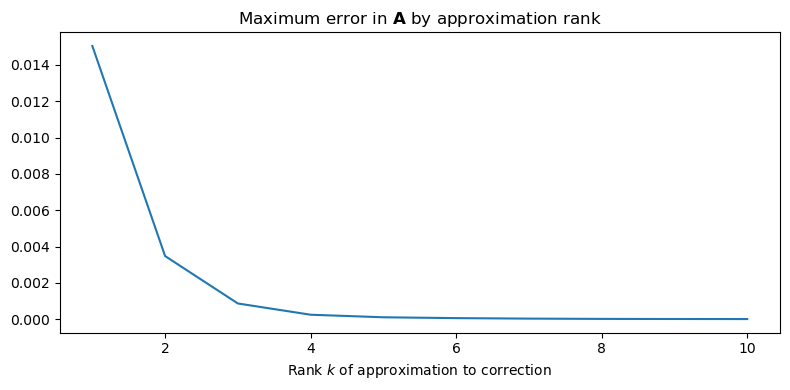

In [35]:
errs = np.empty(10)
for rk in range(1, 11):
    errs[rk-1] = np.max(np.abs(E_A - U[:, :rk] @ np.diag(s[:rk]) @ Vh[:rk, :]))
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), errs)
plt.xlabel('Rank $k$ of approximation to correction')
plt.title('Maximum error in $\mathbf{A}$ by approximation rank')
plt.tight_layout()
#plt.savefig('figmatt/approximation_error.png', dpi=300, transparent=True)

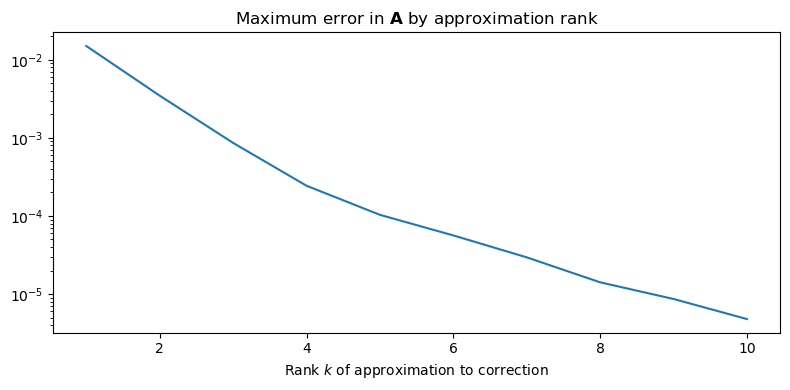

In [36]:
# same thing with a log 10 plot
plt.figure(figsize=(8, 4))
plt.semilogy(range(1, 11), errs)
plt.xlabel('Rank $k$ of approximation to correction')
plt.title('Maximum error in $\mathbf{A}$ by approximation rank')
plt.tight_layout()
#plt.savefig('figmatt/approximation_error_log.png', dpi=300, transparent=True)

Now let's do the same thing for $\mathbf{A}^{-1}$, but cutting off things closer to $T$ to avoid truncation artifacts.

In [37]:
Tsm = 500
Ainv = np.linalg.inv(A)[:Tsm, :Tsm] # don't look near T, truncation artifacts
T_Ainv = linalg.toeplitz(Ainv[Tsm-1, :][::-1], Ainv[:, Tsm-1][::-1])
E_Ainv = Ainv - T_Ainv

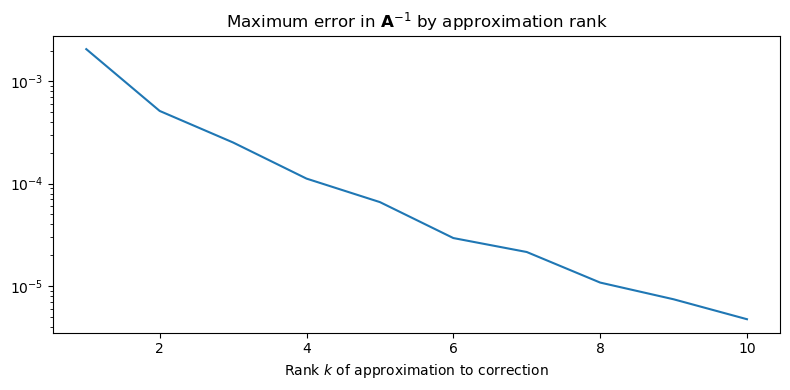

In [38]:
U, s, Vh = np.linalg.svd(E_Ainv)
for rk in range(1, 11):
    errs[rk-1] = np.max(np.abs(E_Ainv - U[:, :rk] @ np.diag(s[:rk]) @ Vh[:rk, :]))
plt.figure(figsize=(8, 4))
plt.semilogy(range(1, 11), errs)
plt.xlabel('Rank $k$ of approximation to correction')
plt.title('Maximum error in $\mathbf{A}^{-1}$ by approximation rank')
plt.tight_layout()
#plt.savefig('figmatt/approximation_error_inv.png', dpi=300, transparent=True)